In [2]:
pip install mysql-connector-python

   ---------------------------------------- 0.0/16.1 MB ? eta -:--:--
    --------------------------------------- 0.3/16.1 MB ? eta -:--:--
   -- ------------------------------------- 1.0/16.1 MB 3.9 MB/s eta 0:00:04
   --- ------------------------------------ 1.6/16.1 MB 3.4 MB/s eta 0:00:05
   ------ --------------------------------- 2.6/16.1 MB 3.6 MB/s eta 0:00:04
   ------- -------------------------------- 3.1/16.1 MB 3.6 MB/s eta 0:00:04
   --------- ------------------------------ 3.9/16.1 MB 3.5 MB/s eta 0:00:04
   ----------- ---------------------------- 4.7/16.1 MB 3.5 MB/s eta 0:00:04
   ------------- -------------------------- 5.2/16.1 MB 3.4 MB/s eta 0:00:04
   -------------- ------------------------- 6.0/16.1 MB 3.4 MB/s eta 0:00:03
   ---------------- ----------------------- 6.8/16.1 MB 3.4 MB/s eta 0:00:03
   ------------------ --------------------- 7.6/16.1 MB 3.4 MB/s eta 0:00:03
   -------------------- ------------------- 8.1/16.1 MB 3.4 MB/s eta 0:00:03
   ----------

In [4]:
pip install seaborn


In [6]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='*********',
    database='himanshudb'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\91897\OneDrive\Desktop\ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [8]:
db = mysql.connector.connect( host = "localhost",
                             username = "root",
                             password = "Gandhi420",
                             database = "himanshudb")
cur = db.cursor()

# List all unique the cities where customers are located.

In [92]:
query = """ select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)

df.head(10)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# count numbers of orders placed in 2017

In [36]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders purchased in 2017 are" , data [0][0]

('total orders purchased in 2017 are', 45101)

## Find total sales per category

In [56]:
query = """ select upper(p.product_category) , round(sum(py.payment_value),2) sales
from products p join order_items using(product_id) 
join payments py using(order_id)
group by p.product_category"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category" , "sales"])
df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.


In [67]:
query = """ select (sum( case when payment_installments >= 1 then 1 
else 0 end)/count(*))*1000 from payments"""

cur.execute(query)

data = cur.fetchall()

"percentage of orders that were paid in installments are", data[0][0]


('percentage of orders that were paid in installments are',
 Decimal('999.9807'))

# Count the number of customers from each state. 

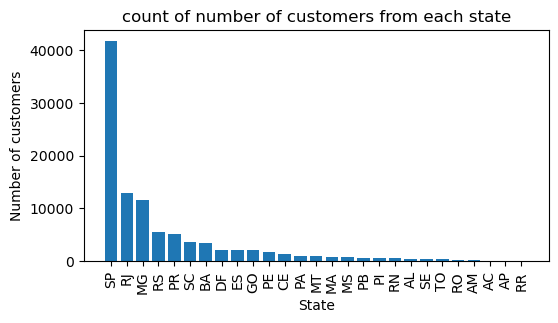

In [150]:
query = """ select customer_state, count(customer_id) 
from customers 
group by customer_state"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ["state", "customer_count"])

df = df.sort_values(by = "customer_count", ascending = False)

plt.figure(figsize = (6,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks (rotation = 90)
plt.title("count of number of customers from each state")
plt.xlabel("State")
plt.ylabel("Number of customers")
plt.show()


# Calculate the number of orders per month in 2018.


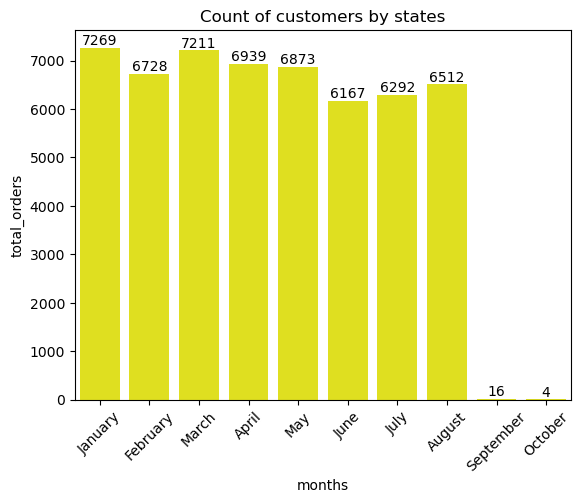

<Figure size 600x300 with 0 Axes>

In [154]:
query = """ SELECT  monthname(order_purchase_timestamp), count(order_id) as mn
 from himanshudb.orders 
 where year(order_purchase_timestamp) = 2018
 group by monthname(order_purchase_timestamp)
 order by mn """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns =  ["months", "total_orders"])

df

o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]

ax = sns.barplot(x = df["months"], y = df["total_orders"], data = df, order = o, color = "yellow", )
ax.bar_label(ax.containers[0])
plt.title("Count of customers by states")
plt.xticks(rotation = 45)
plt.figure(figsize = (6,3))

plt.show()
                  

    



# Find the average number of products per order, grouped by customer city.

In [21]:
query = """ with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items using(order_id)
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) 
from customers join count_per_order using(customer_id)
group by customers.customer_city; """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["city_name" , "avg_Num_products_per_order"])
df.head(5)


,city_name,avg_Num_products_per_order
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27


# Calculate the percentage of total revenue contributed by each product category.


In [11]:

query = """ select upper(p.product_category) , 
round((sum(py.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products p join order_items using(product_id) 
join payments py using(order_id)
group by p.product_category """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns= ["category", "sales_percentage"])
df.head(5)

,category,sales_percentage
0,PERFUMERY,3.17
1,FURNITURE DECORATION,8.93
2,TELEPHONY,3.04
3,BED TABLE BATH,10.70
4,AUTOMOTIVE,5.32


# Identify the correlation between product price and the number of times a product has been purchased.

In [25]:
query = """ select upper(products.product_category) , 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items using(product_id)
group by products.product_category;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["product_category", "number_of_products", "average_price"])
df.head(5)

arr1 = df["number_of_products"]
arr2 = df["average_price"]

co_relation = np.corrcoef([arr1,arr2])
co_relation = np.round(co_relation,3)
print("Corelation between number of products sold and price is", co_relation[0][1])

Corelation between number of products sold and price is -0.106


# Calculate the total revenue generated by each seller, and rank them by revenue.


In [34]:
query = """ select  * , dense_rank() over (order by revenue desc) from
(SELECT oi.seller_id, round(sum(payments.payment_value),2) as revenue
from order_items as oi join payments using(order_id)
group by oi.seller_id
order by revenue desc) as a;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,  columns = ["seller_id", "revenue", "ranking"])
df.head(5)

,seller_id,revenue,ranking
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


#  Calculate the moving average of order values for each customer over their order history.

In [39]:
query = """ select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by  order_purchase_timestamp
 rows between 2 preceding and current row)  as moving_avg
from (SELECT orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from payments join orders using(order_id))as a;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id", "date_time", "payment", "moving_average"])
df

,customer_id,date_time,payment,moving_average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

In [46]:
query = """ select round(sum(payment) over(partition by yr
 order by yr,mnth rows between
 11 preceding and current row),2) as sum, 
mnth, yr
 from 
(select sum(payments.payment_value) as payment,
month(orders.order_purchase_timestamp) as mnth, 
year(orders.order_purchase_timestamp) as yr
from payments join orders using(order_id)
group by mnth, yr
order by mnth, yr) as a
order by yr, mnth ;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Cumulative_sales", "month", "year"])
df


,Cumulative_sales,month,year
0,252.24,9,2016
1,59342.72,10,2016
2,59362.34,12,2016
3,138488.04,1,2017
4,430396.05,2,2017
5,880259.65,3,2017
6,1298047.68,4,2017
7,1890966.50,5,2017
8,2402242.88,6,2017
9,2994625.80,7,2017


# Calculate the year-over-year growth rate of total sales.

In [59]:
query = """with cte as (select round(sum(payments.payment_value),2) as payment,
year(orders.order_purchase_timestamp) as yr
from payments join orders using(order_id)
group by  yr),
cte2 as (select payment, yr, 
lag(payment,1) over (order by yr) as previous_year
from cte)
select yr, round(((payment - previous_year)/ previous_year)*100,3)  as yoy
from cte2"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["year", "yoy growth rate"])
df


,year,yoy growth rate
0,2016,NaN
1,2017,12112.704
2,2018,20.001


# Identify the top 3 customers who spent the most money in each year.

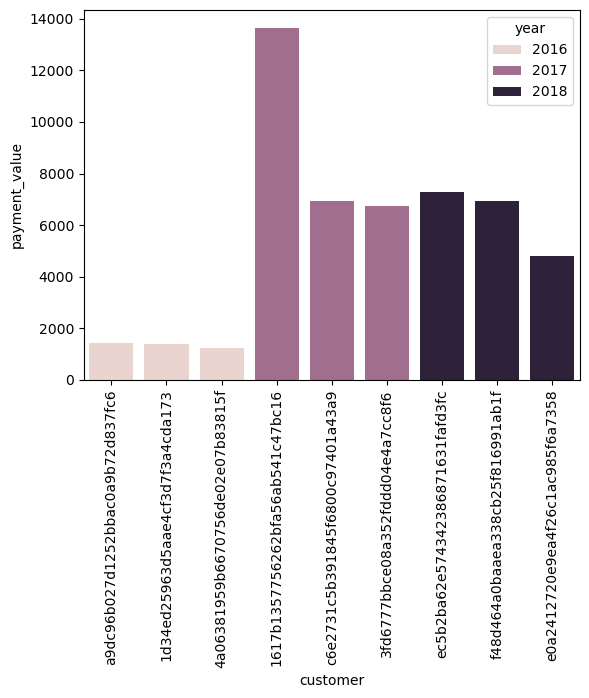

In [67]:
query = """ with cte as ( select rank() over(partition by year(orders.order_purchase_timestamp) order by payments.payment_value desc ) as ranking,
payments.payment_value as pv, year(orders.order_purchase_timestamp) as yrs ,orders.customer_id as customer
from payments join orders using(order_id) )
select * from cte where ranking <= 3;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["ranking","payment_value", "year", "customer"])
df
sns.barplot(x = "customer", y = "payment_value", data = df, hue = "year")
plt.xticks(rotation = 90)
plt.show()
